# C_a_1 : Création des features

Le but de cette section est de créer des caractéristiques (ou *features*) 

### Inspirations :
- https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet-yt/notebook
- https://colab.research.google.com/drive/1b3CUJuDOmPmNdZFH3LQDmt5F0K3FZhqD?usp=sharing#scrollTo=J-YOd8tLhpE0
- duction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0

### À faire : 
- [x] Création des features sur la date (jour, mois, saison, etc.)
- [x] Création des features sur la température (lag, window, delta, etc.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import locale
import calendar
from references import *
from src import *

import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None

locale.setlocale(locale.LC_ALL, "fr_CA.UTF-8")

'fr_CA.UTF-8'

In [2]:
%load_ext jupyter_black

# import black
# import jupyter_black

# jupyter_black.load(
#     lab=True,
#     line_length=55,
#     target_version=black.TargetVersion.PY311,
# )

## Import des données

In [3]:
def import_data(dep="20190101", fin="20221231"):
    path_to_interim_data = "../data/interim/"
    demande_meteo_parquet = "demande_meteo.parquet"

    df_import = pd.read_parquet(
        path=os.path.join(path_to_interim_data, demande_meteo_parquet),
        engine="pyarrow",
    )
    return df_import[dep:fin]

In [4]:
df = import_data()

## Features sur les dates

In [5]:
def create_date_features(df):
    """
    Création des features concernant les dates
    """
    df = df.copy()
    df["date"] = df.index
    df["hourofday"] = df["date"].dt.hour
    df["dayofweek"] = df["date"].dt.dayofweek
    df["quarter"] = df["date"].dt.quarter
    df["year"] = df["date"].dt.year
    df["dayofyear"] = df["date"].dt.dayofyear
    df["dayofmonth"] = df["date"].dt.day
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype("int32")

    # Saisons
    df["date_offset"] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300
    df["season"] = pd.cut(
        df["date_offset"],
        [0, 300, 602, 900, 1300],
        labels=[
            "Printemps",
            "Été",
            "Automne",
            "Hiver",
        ],
    )

    # Mois et jour comme variable "catégorie"
    df["idx_Mois"] = df.index.month
    df["idx_Jour"] = df.index.dayofweek

    df["month"] = (
        df["idx_Mois"]
        .apply(lambda x: calendar.month_name[x].capitalize())
        .astype(mois_cat_type)
    )
    df["weekday"] = (
        df["idx_Jour"]
        .apply(lambda x: calendar.day_name[x].capitalize())
        .astype(jours_cat_type)
    )

    df["weekend_day"] = df["idx_Jour"].apply(lambda x: 1 if x in [5, 6] else 0)

    # Application d'un cycle sur la durée du jour et de l'année
    # [-1 : 1] avec sinus et cosinus
    day = 60 * 60 * 24
    year = 365.2425 * day

    df["Seconds"] = df.index.map(pd.Timestamp.timestamp)

    df["day_sin"] = np.sin(df["Seconds"] * (2 * np.pi / day))
    df["day_cos"] = np.cos(df["Seconds"] * (2 * np.pi / day))
    df["year_sin"] = np.sin(df["Seconds"] * (2 * np.pi / year))
    df["year_cos"] = np.cos(df["Seconds"] * (2 * np.pi / year))

    # Éliminons les colonnes non requises
    df = df.drop(columns=["date", "Seconds", "date_offset", "idx_Jour", "idx_Mois"])

    return df

In [6]:
df = create_date_features(df)

print("Un exemple de donnée :")
df.iloc[25]

Un exemple de donnée :


MW             26273.19
Temp              -14.4
hourofday             1
dayofweek             2
quarter               1
year               2019
dayofyear             2
dayofmonth            2
weekofyear            1
season            Hiver
month           Janvier
weekday        Mercredi
weekend_day           0
day_sin        0.258819
day_cos        0.965926
year_sin        0.01994
year_cos       0.999801
Name: 2019-01-02 01:00:00, dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35068 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   MW           35018 non-null  float64 
 1   Temp         35068 non-null  float64 
 2   hourofday    35068 non-null  int32   
 3   dayofweek    35068 non-null  int32   
 4   quarter      35068 non-null  int32   
 5   year         35068 non-null  int32   
 6   dayofyear    35068 non-null  int32   
 7   dayofmonth   35068 non-null  int32   
 8   weekofyear   35068 non-null  int32   
 9   season       34972 non-null  category
 10  month        35068 non-null  category
 11  weekday      35068 non-null  category
 12  weekend_day  35068 non-null  int64   
 13  day_sin      35068 non-null  float64 
 14  day_cos      35068 non-null  float64 
 15  year_sin     35068 non-null  float64 
 16  year_cos     35068 non-null  float64 
dtypes: category(3), float64(6), int32(

In [8]:
df.head(3)

,MW,Temp,hourofday,dayofweek,quarter,year,dayofyear,dayofmonth,weekofyear,season,month,weekday,weekend_day,day_sin,day_cos,year_sin,year_cos
date,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0.0,0,1,1,2019,1,1,1,Hiver,Janvier,Mardi,0,-5.030095e-12,1.000000,0.002021,0.999998
2019-01-01 01:00:00,23762.55,0.0,1,1,1,2019,1,1,1,Hiver,Janvier,Mardi,0,2.588190e-01,0.965926,0.002738,0.999996
2019-01-01 02:00:00,23830.23,-0.2,2,1,1,2019,1,1,1,Hiver,Janvier,Mardi,0,5.000000e-01,0.866025,0.003455,0.999994


## Visualisation de quelques *features* basés sur la date

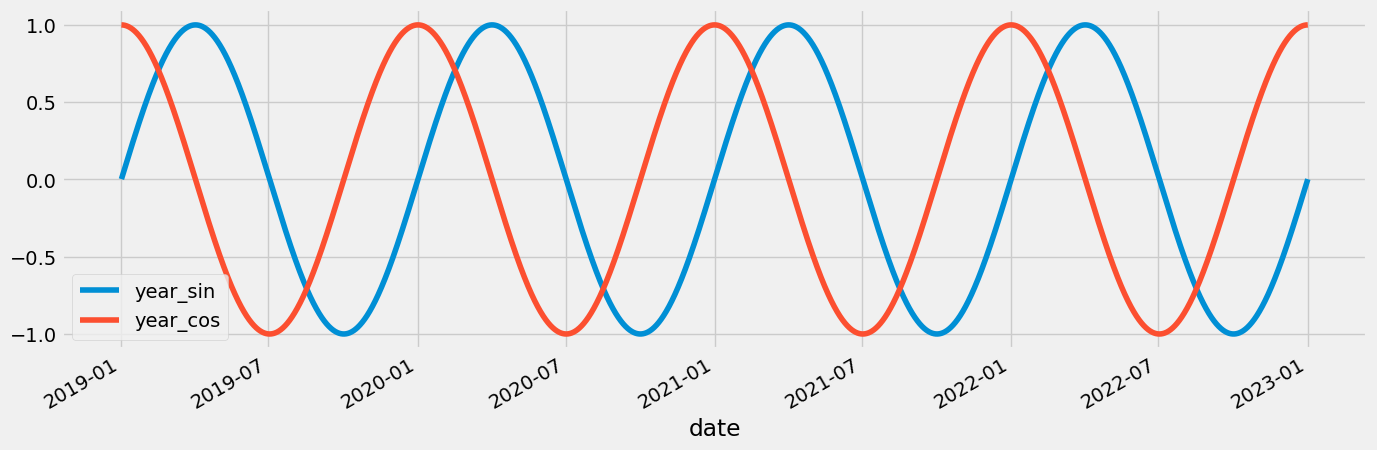

In [9]:
df[["year_sin", "year_cos"]].plot(figsize=(15, 5))
plt.show()

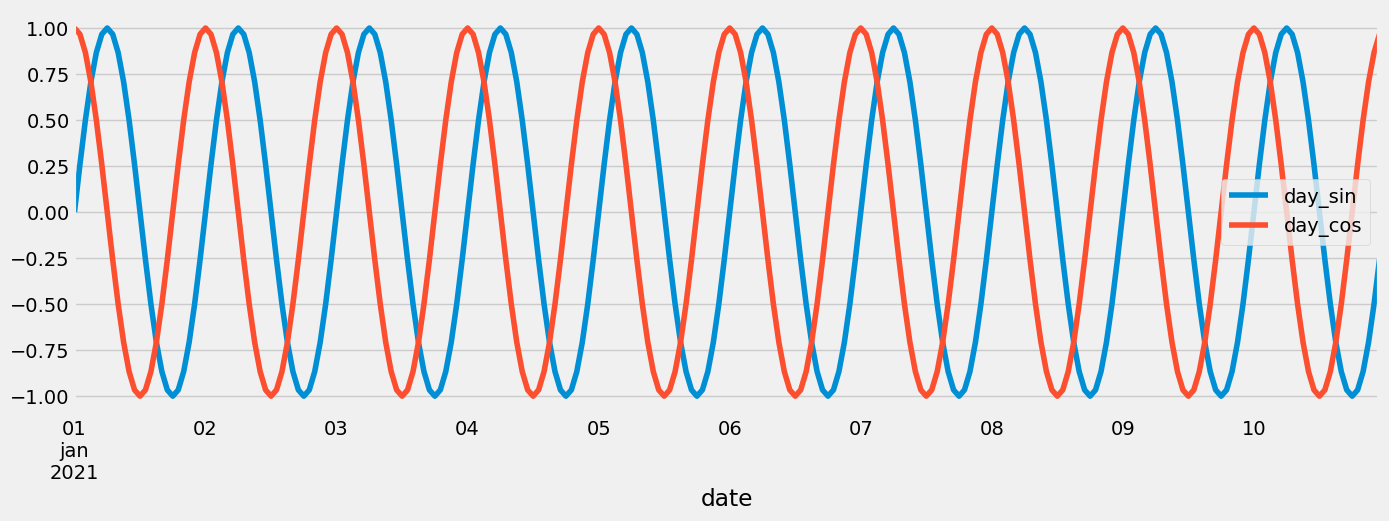

In [10]:
df[["day_sin", "day_cos"]]["20210101":"20210110"].plot(figsize=(15, 5))
plt.show()

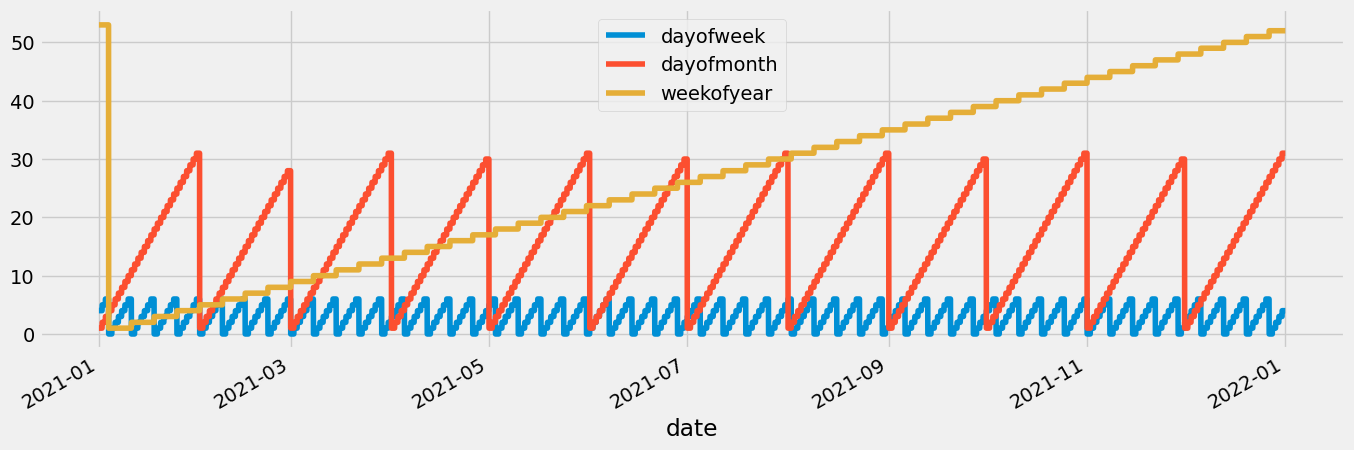

In [11]:
df[["dayofweek", "dayofmonth", "weekofyear"]]["20210101":"20211231"].plot(
    figsize=(15, 5)
)
plt.show()

## *Features* sur la température

### Différence des températures

Nous savons que les degrés-jour sont une méthode pour calculer les besoins de chauffage et de climatisation dans le bâtiment. 

Nous voyons souvent dans la documentation des HDD (Heating Degree Days) en base 18C, c'est-à-dire qu'aucun chauffage n'est requis en haut de 18 et que plus on s'éloigne de cette température, plus le chauffage sera requis.

La même chose s'applique en CDD (Cooling Degree Days), mais en base 21C. 

D'autres sources utilisent 24 et 16. Calculons plusieurs écarts à ces températures de même que des intervalles centrés sur 18 et 21C. 

Ref :
- https://www.iea.org/data-and-statistics/charts/cooling-degree-days-in-canada-2000-2020
- https://www.iea.org/data-and-statistics/charts/heating-degree-days-in-canada-2000-2020
- https://www.investopedia.com/terms/h/heatingdegreeday.asp


In [12]:
def create_deltaTemp_features(df):
    """
    Création des features concernant les dates
    """
    df = df.copy()

    base_CDD_21 = 21
    base_CDD_24 = 24
    base_HDD_18 = 18
    base_HDD_16 = 16

    df["CDD_21"] = df.Temp.apply(lambda t: 0 if t <= base_CDD_21 else t - base_CDD_21)
    df["HDD_18"] = df.Temp.apply(lambda t: 0 if t >= base_HDD_18 else base_HDD_18 - t)
    df["CDD_24"] = df.Temp.apply(lambda t: 0 if t <= base_CDD_24 else t - base_CDD_24)
    df["HDD_16"] = df.Temp.apply(lambda t: 0 if t >= base_HDD_16 else base_HDD_16 - t)

    df["DT_18-21"] = df["HDD_18"] + df["CDD_21"]
    df["DT_16-24"] = df["HDD_16"] + df["CDD_24"]

    df["DT_18"] = abs(df["Temp"] - base_HDD_18)
    df["DT_21"] = abs(df["Temp"] - base_CDD_21)

    return df

In [13]:
df = create_deltaTemp_features(df)
df

,MW,Temp,hourofday,dayofweek,quarter,year,dayofyear,dayofmonth,weekofyear,season,...,year_sin,year_cos,CDD_21,HDD_18,CDD_24,HDD_16,DT_18-21,DT_16-24,DT_18,DT_21
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0.0,0,1,1,2019,1,1,1,Hiver,...,0.002021,0.999998,0.0,18.0,0.0,16.0,18.0,16.0,18.0,21.0
2019-01-01 01:00:00,23762.55,0.0,1,1,1,2019,1,1,1,Hiver,...,0.002738,0.999996,0.0,18.0,0.0,16.0,18.0,16.0,18.0,21.0
2019-01-01 02:00:00,23830.23,-0.2,2,1,1,2019,1,1,1,Hiver,...,0.003455,0.999994,0.0,18.2,0.0,16.2,18.2,16.2,18.2,21.2
2019-01-01 03:00:00,23608.07,-0.5,3,1,1,2019,1,1,1,Hiver,...,0.004172,0.999991,0.0,18.5,0.0,16.5,18.5,16.5,18.5,21.5
2019-01-01 04:00:00,23562.48,-1.0,4,1,1,2019,1,1,1,Hiver,...,0.004888,0.999988,0.0,19.0,0.0,17.0,19.0,17.0,19.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,23381.99,1.9,19,5,4,2022,365,31,52,Hiver,...,-0.001047,0.999999,0.0,16.1,0.0,14.1,16.1,14.1,16.1,19.1
2022-12-31 20:00:00,22627.35,2.5,20,5,4,2022,365,31,52,Hiver,...,-0.000330,1.000000,0.0,15.5,0.0,13.5,15.5,13.5,15.5,18.5
2022-12-31 21:00:00,22004.14,2.1,21,5,4,2022,365,31,52,Hiver,...,0.000387,1.000000,0.0,15.9,0.0,13.9,15.9,13.9,15.9,18.9


## Visualisation des **delta température**

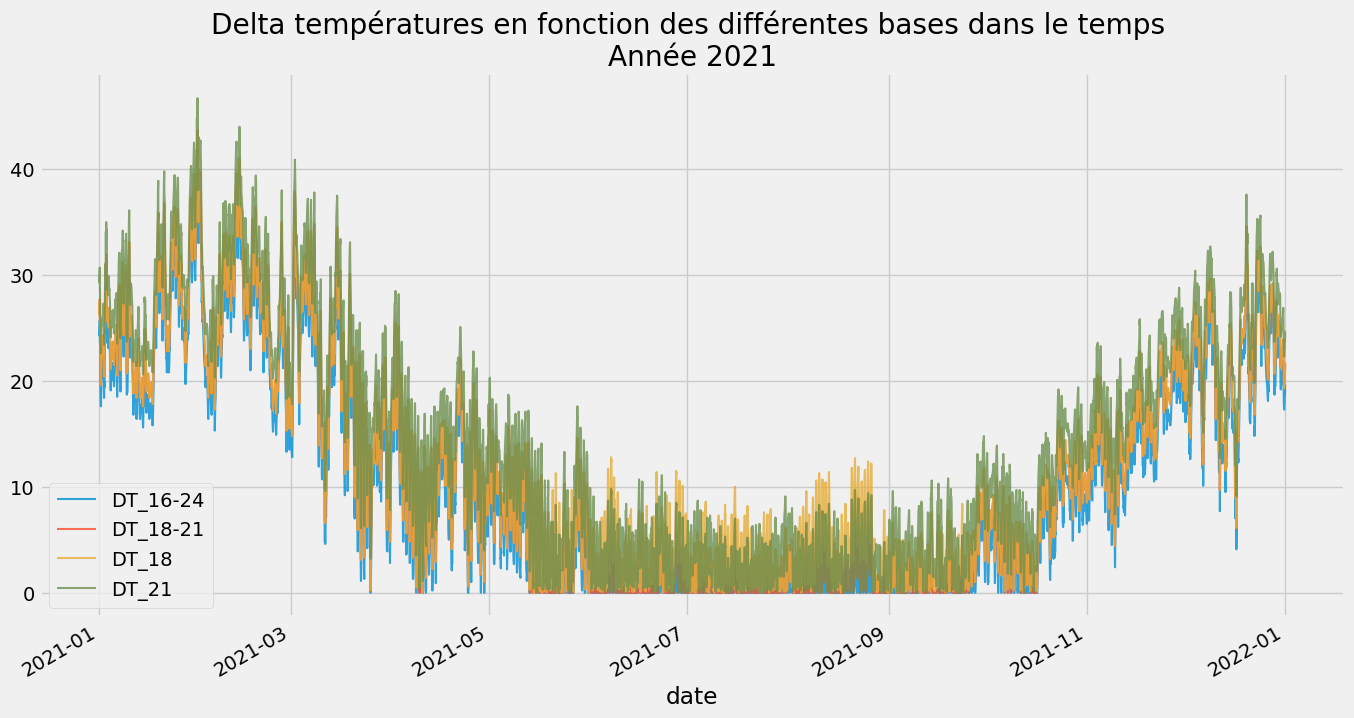

In [14]:
df[["DT_16-24", "DT_18-21", "DT_18", "DT_21"]]["20210101":"20211231"].plot(
    figsize=(15, 8),
    linewidth=1.5,
    alpha=0.8,
    title="Delta températures en fonction des différentes bases dans le temps \nAnnée 2021",
)
plt.show()

## Caractéristiques avec délai (*Lags features*)

> Lag features are values at prior timesteps that are considered useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the future. For example, it can be beneficial to generate features for sales that happened in previous days at 4:00 p.m. if you want to predict similar sales at 4:00 p.m. the next day. (https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0)

Les données des heures précédentes peuvent avoir un effet sur les heures suivantes.  Avec la fonction `shift`, nous regardons la donnée il y a X heures. 

Ref:  https://stackoverflow.com/questions/48818213/make-multiple-shifted-lagged-columns-in-pandas

In [15]:
def create_lag_features(
    df,
    caract=["Temp", "DT_18-21", "DT_16-24", "DT_18", "DT_21"],
    lags=[1, 2, 3, 4, 6, 24],
):
    """
    Création des caractéristiques avec délai (lag ou shift)
    """
    df = df.copy()

    df_lag = df[caract]

    df_lagged = df_lag.assign(
        **{f"{col}_LAG_t-{lag}h": df[col].shift(lag) for lag in lags for col in df_lag},
    )

    return df.join(df_lagged.drop(columns=df_lag.columns.to_list(), axis=1))

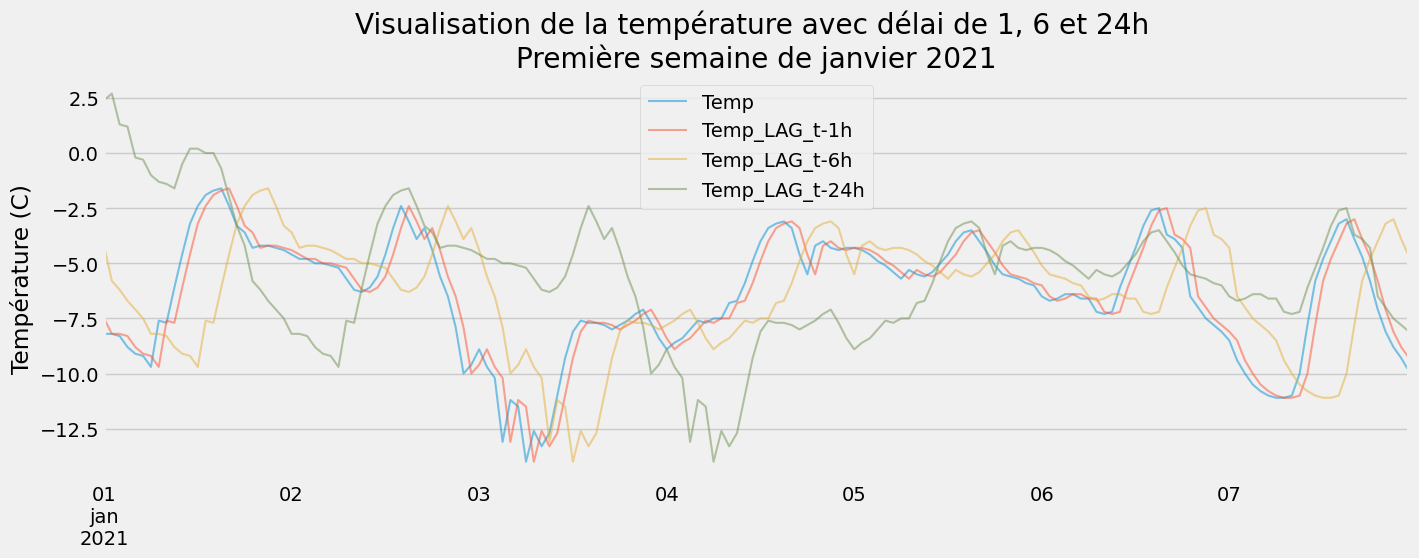

In [16]:
df = create_lag_features(df)

df[["Temp", "Temp_LAG_t-1h", "Temp_LAG_t-6h", "Temp_LAG_t-24h"]][
    "20210101":"20210107"
].plot(
    linewidth=1.5,
    alpha=0.5,
    figsize=(15, 5),
    ylabel="Température (C)",
    xlabel="",
    title="Visualisation de la température avec délai de 1, 6 et 24h \nPremière semaine de janvier 2021",
)
plt.show()

Nous pouvons bien voir que c'est la même courbe, mais avec une translation horizontale du nombre d'heures de délais. 

## Caractéristiques avec moyenne mobile (*rolling windows*)

Nous pouvons faire une moyenne sur les heures qui viennent de passer avec des fenêtres de temps différentes.  Il est possible qu'une accumulation de température froide entraîner une plus grande demande électrique contrairement à une chute rapide de température après plusieurs jours chauds (inertie thermique des bâtiments).

https://stackoverflow.com/questions/36937869/sliding-window-over-pandas-dataframe

In [17]:
def create_window_features(
    df,
    caract=["Temp", "DT_18-21", "DT_16-24", "DT_18", "DT_21"],
    fenetres=[1, 2, 3, 4, 6, 24],
):
    """
    Création des caractéristiques avec moyenne mobile (rolling windows)
    """
    df = df.copy()

    df_fen = df[caract]

    df_fenetres = df_fen.assign(
        **{
            f"{col}_MOYMOBILE_t-{fenetre}h": df[col].rolling(fenetre).mean()
            for fenetre in fenetres
            for col in df_fen
        },
    )

    return df.join(df_fenetres.drop(df_fen.columns.to_list(), axis=1))

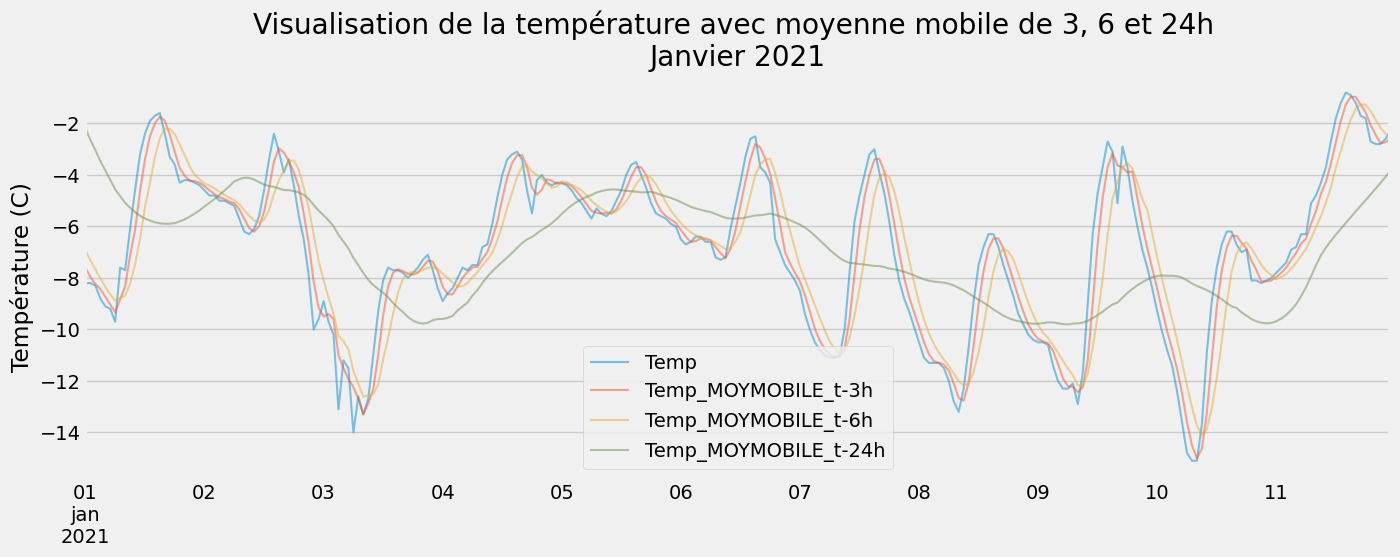

In [18]:
df = create_window_features(df)

df[["Temp", "Temp_MOYMOBILE_t-3h", "Temp_MOYMOBILE_t-6h", "Temp_MOYMOBILE_t-24h"]][
    "20210101":"20210111"
].plot(
    linewidth=1.5,
    alpha=0.5,
    figsize=(15, 5),
    ylabel="Température (C)",
    xlabel="",
    title="Visualisation de la température avec moyenne mobile de 3, 6 et 24h \nJanvier 2021",
)
plt.show()

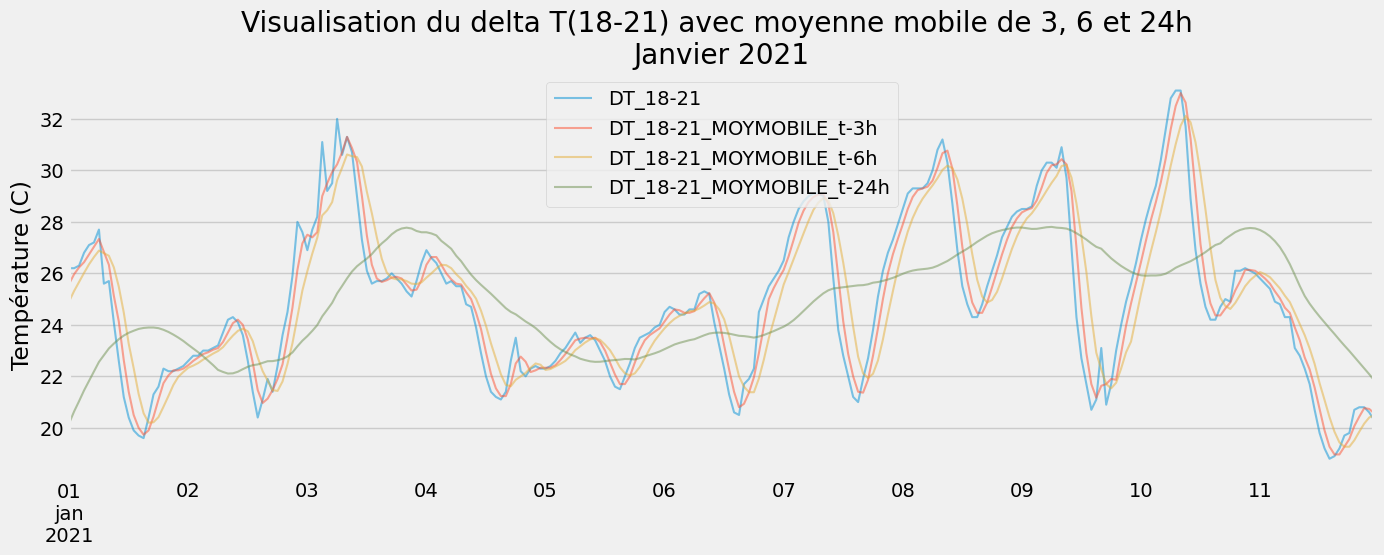

In [19]:
df[
    [
        "DT_18-21",
        "DT_18-21_MOYMOBILE_t-3h",
        "DT_18-21_MOYMOBILE_t-6h",
        "DT_18-21_MOYMOBILE_t-24h",
    ]
]["20210101":"20210111"].plot(
    linewidth=1.5,
    alpha=0.5,
    figsize=(15, 5),
    ylabel="Température (C)",
    xlabel="",
    title="Visualisation du delta T(18-21) avec moyenne mobile de 3, 6 et 24h \nJanvier 2021",
)
plt.show()

Nous pouvons voir que les courbes sont de plus en plus lisses à mesure que le temps utilisé dans la moyenne mobile augmente. 

## Cycle complet d'inmport des données et création des caractéristiques

In [23]:
df = import_data()
df = create_date_features(df)
df = create_deltaTemp_features(df)
df = create_lag_features(df)
df = create_window_features(df)
print(df.columns.to_list())
df.head(10)

['MW', 'Temp', 'hourofday', 'dayofweek', 'quarter', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'season', 'month', 'weekday', 'weekend_day', 'day_sin', 'day_cos', 'year_sin', 'year_cos', 'CDD_21', 'HDD_18', 'CDD_24', 'HDD_16', 'DT_18-21', 'DT_16-24', 'DT_18', 'DT_21', 'Temp_LAG_t-1h', 'DT_18-21_LAG_t-1h', 'DT_16-24_LAG_t-1h', 'DT_18_LAG_t-1h', 'DT_21_LAG_t-1h', 'Temp_LAG_t-2h', 'DT_18-21_LAG_t-2h', 'DT_16-24_LAG_t-2h', 'DT_18_LAG_t-2h', 'DT_21_LAG_t-2h', 'Temp_LAG_t-3h', 'DT_18-21_LAG_t-3h', 'DT_16-24_LAG_t-3h', 'DT_18_LAG_t-3h', 'DT_21_LAG_t-3h', 'Temp_LAG_t-4h', 'DT_18-21_LAG_t-4h', 'DT_16-24_LAG_t-4h', 'DT_18_LAG_t-4h', 'DT_21_LAG_t-4h', 'Temp_LAG_t-6h', 'DT_18-21_LAG_t-6h', 'DT_16-24_LAG_t-6h', 'DT_18_LAG_t-6h', 'DT_21_LAG_t-6h', 'Temp_LAG_t-24h', 'DT_18-21_LAG_t-24h', 'DT_16-24_LAG_t-24h', 'DT_18_LAG_t-24h', 'DT_21_LAG_t-24h', 'Temp_MOYMOBILE_t-1h', 'DT_18-21_MOYMOBILE_t-1h', 'DT_16-24_MOYMOBILE_t-1h', 'DT_18_MOYMOBILE_t-1h', 'DT_21_MOYMOBILE_t-1h', 'Temp_MOYMOBILE_t-2h', 'DT

,MW,Temp,hourofday,dayofweek,quarter,year,dayofyear,dayofmonth,weekofyear,season,...,Temp_MOYMOBILE_t-6h,DT_18-21_MOYMOBILE_t-6h,DT_16-24_MOYMOBILE_t-6h,DT_18_MOYMOBILE_t-6h,DT_21_MOYMOBILE_t-6h,Temp_MOYMOBILE_t-24h,DT_18-21_MOYMOBILE_t-24h,DT_16-24_MOYMOBILE_t-24h,DT_18_MOYMOBILE_t-24h,DT_21_MOYMOBILE_t-24h
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0.0,0,1,1,2019,1,1,1,Hiver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,23762.55,0.0,1,1,1,2019,1,1,1,Hiver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,23830.23,-0.2,2,1,1,2019,1,1,1,Hiver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,23608.07,-0.5,3,1,1,2019,1,1,1,Hiver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,23562.48,-1.0,4,1,1,2019,1,1,1,Hiver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 05:00:00,23546.16,-1.1,5,1,1,2019,1,1,1,Hiver,...,-0.466667,18.466667,16.466667,18.466667,21.466667,NaN,NaN,NaN,NaN,NaN
2019-01-01 06:00:00,23752.90,-1.0,6,1,1,2019,1,1,1,Hiver,...,-0.633333,18.633333,16.633333,18.633333,21.633333,NaN,NaN,NaN,NaN,NaN
2019-01-01 07:00:00,24022.19,-1.4,7,1,1,2019,1,1,1,Hiver,...,-0.866667,18.866667,16.866667,18.866667,21.866667,NaN,NaN,NaN,NaN,NaN
2019-01-01 08:00:00,24190.08,-1.4,8,1,1,2019,1,1,1,Hiver,...,-1.066667,19.066667,17.066667,19.066667,22.066667,NaN,NaN,NaN,NaN,NaN


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35124 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 85 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   MW                        35074 non-null  float64 
 1   Temp                      35124 non-null  float64 
 2   hourofday                 35124 non-null  int32   
 3   dayofweek                 35124 non-null  int32   
 4   quarter                   35124 non-null  int32   
 5   year                      35124 non-null  int32   
 6   dayofyear                 35124 non-null  int32   
 7   dayofmonth                35124 non-null  int32   
 8   weekofyear                35124 non-null  int32   
 9   season                    35028 non-null  category
 10  month                     35124 non-null  category
 11  weekday                   35124 non-null  category
 12  weekend_day               35124 non-null  int64   
 13  day_sin    

## Création d'un script de création des caractéristiques

Afin de rendre automatique la création de caractéristiques, nous intégrons les fonctions précédentes dans le fichier `src/features/build_features.py`.  Ce fichier permet d'obtenir le dataframe incluant toutes les caractéristiques calculées.


```python
def import_and_create_features(
    dep="20190101",
    fin="20221231",
    caract: [str] = ["Temp", "DT_18-21", "DT_16-24", "DT_18", "DT_21"],
    lags: [int] = [1, 2, 3, 4, 6, 24],
    fenetres: [int] = [1, 2, 3, 4, 6, 24],
) -> pd.DataFrame:
    df = import_data(dep=dep, fin=fin)
    df = create_date_features(df=df)
    df = create_deltaTemp_features(df=df)
    df = create_lag_features(df=df, caract=caract, lags=lags)
    df = create_window_features(df=df, caract=caract, fenetres=fenetres)

    return df
```

Des valeurs par défault ont été utilisées, mais il est possible de modifier les dates, les caractéristiques à modeler et les délais et fenêtres mobiles.

Comme nous obtenons plus de 80 colonnes, il sera préférable de valider si toutes ces informations sont utiles au modèle. 

De plus, comme il est possible de les créer rapidement, ça ne vaut pas la peine des les enregistrer.  Les *features* seront créés à mesure que les besoins subviendront. 

In [22]:
import_and_create_features()

,MW,Temp,hourofday,quarter,year,dayofyear,dayofmonth,weekofyear,season,month,...,Temp_MOYMOBILE_t-6h,DT_18-21_MOYMOBILE_t-6h,DT_16-24_MOYMOBILE_t-6h,DT_18_MOYMOBILE_t-6h,DT_21_MOYMOBILE_t-6h,Temp_MOYMOBILE_t-24h,DT_18-21_MOYMOBILE_t-24h,DT_16-24_MOYMOBILE_t-24h,DT_18_MOYMOBILE_t-24h,DT_21_MOYMOBILE_t-24h
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0.0,0,1,2019,1,1,1,Hiver,Janvier,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,23762.55,0.0,1,1,2019,1,1,1,Hiver,Janvier,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,23830.23,-0.2,2,1,2019,1,1,1,Hiver,Janvier,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,23608.07,-0.5,3,1,2019,1,1,1,Hiver,Janvier,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00,23562.48,-1.0,4,1,2019,1,1,1,Hiver,Janvier,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,23381.99,1.9,19,4,2022,365,31,52,Hiver,Décembre,...,2.333333,15.666667,13.666667,15.666667,18.666667,3.479167,14.520833,12.520833,14.520833,17.520833
2022-12-31 20:00:00,22627.35,2.5,20,4,2022,365,31,52,Hiver,Décembre,...,2.266667,15.733333,13.733333,15.733333,18.733333,3.395833,14.604167,12.604167,14.604167,17.604167
2022-12-31 21:00:00,22004.14,2.1,21,4,2022,365,31,52,Hiver,Décembre,...,2.083333,15.916667,13.916667,15.916667,18.916667,3.320833,14.679167,12.679167,14.679167,17.679167


# Conclusion de la section et apprentissages

Nous avons préparés de caractéristiques dans cette section qui nous servirons à créer des modèles d'apprentissage machine dans les prochaines étapes.

Ces caractéristiques dépendent toutes des données temporelles, soit les dates et heures de données, de même que des données que nous connaissons, soit la température. Il sera possible de les calculer lorsque nous entraînerons et utiliserons le modèle. 

Nous utilisons nos connaissances des phénomènes physiques (base de chauffage et clim en base 18C ou impact de la durée des grands frois sur la demande (moyenne mobile)) afin d'aider le modèle que nous entraînerons dans les prochaines sections. 

Lors de l'entraînement des modèles, il faudra voir si ça vaut la peine de conserver l'ensemble des caractéristiques préparées dans cette section : il sera inutile de conserver des variables qui n'ont pas de poids dans le modèle. 